In [1]:
# step 1 import the library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [11]:
#step 2 read the dataset

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

sns.set(style="whitegrid")
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
#EDA STEP 3 EXPLOTARY DATA ANALIISSYS

# Check missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

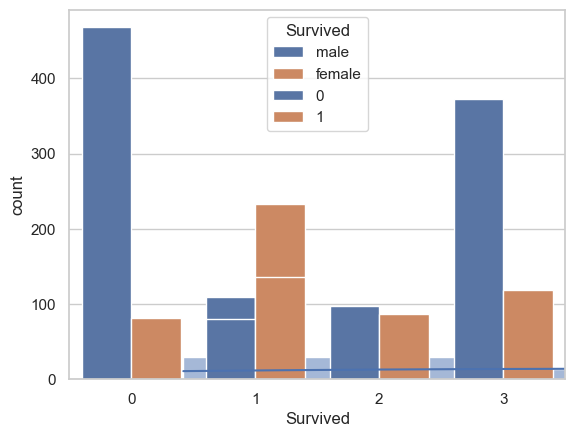

In [13]:


# Visualize survival by sex
sns.countplot(x='Survived', hue='Sex', data=train)

# Visualize age distribution
sns.histplot(data=train, x='Age', bins=30, kde=True)

# Visualize Pclass survival
sns.countplot(x='Pclass', hue='Survived', data=train)


In [14]:
# step 4 data processing
#fill missing value because we are check in the past code in cabin embarked and age we have missing value so we need to fill
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
train.drop(columns=['Cabin'], inplace=True)



C:\Users\USER\AppData\Local\Temp\ipykernel_1144\4128294871.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_1144\4128294871.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [15]:
# now when fill the missing value we need to encode the dataset to convert all categorical value to numeric value,
#  we are drop cabin so we need to encode only sex and embarked 
#here we use .map for sex because we have only 2 option male or female so we can use binary 0 1 and we use get_dummies for embarked because we have more than 2 option s c Q

train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)


In [17]:
#now we use feuture engineering to predict from the title and name how many people survived

# Extract Title
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = train['Title'].replace(['Mlle', 'Ms'], 'Miss')
train['Title'] = train['Title'].replace(['Mme', 'Lady', 'Countess', 'Dona'], 'Mrs')
train['Title'] = train['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Sir', 'Jonkheer', 'Don'], 'Rare')

# FamilySize
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

# AgeGroup
train['AgeGroup'] = pd.cut(train['Age'], bins=[0, 12, 20, 40, 60, 100],
                           labels=['Child', 'Teen', 'Adult', 'Middle-Aged', 'Senior'])

# Encode new categorical features
train = pd.get_dummies(train, columns=['Title', 'AgeGroup'], drop_first=True)


<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
C:\Users\USER\AppData\Local\Temp\ipykernel_1144\2629108621.py:4: SyntaxWarning: invalid escape sequence '\.'
  train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [18]:
#step 5 prepare model 
target = 'Survived'

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize'] + \
           [col for col in train.columns if col.startswith('Embarked_') or
                                               col.startswith('Title_') or
                                               col.startswith('AgeGroup_')]

X = train[features]
y = train[target]


In [19]:
#step 6 model training and evaluation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_val_scaled)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


Accuracy: 0.8156424581005587
[[88 17]
 [16 58]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       105
           1       0.77      0.78      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [20]:
#step 7 check mean score

scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validation Accuracy:", scores.mean())


Cross-Validation Accuracy: 0.7990961019396146
